![](https://storage.googleapis.com/kaggle-competitions/kaggle/7634/logos/header.png)
# TensorFlow Speech Recognition Challenge



## Introduction

[Link to the Competition](https://www.kaggle.com/c/tensorflow-speech-recognition-challenge)

In this competition, participants are challenged to use the **Speech Commands Dataset**  to build an algorithm that understands simple spoken commands. By improving the recognition accuracy of open-sourced voice interface tools, we can improve product effectiveness and their accessibility.

**My Test Task**: 
Implement a classification for the attached dataset. The dataset includes a set of recorded short commands or some random noise.

## Setup

Import necessary modules and dependencies.

In [1]:
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal
from scipy.io import wavfile

from pydub import AudioSegment
import math
import shutil
from shutil import unpack_archive
import gc

import tensorflow as tf

from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models

from IPython import display
import warnings
warnings.filterwarnings("ignore")




# Set seed for experiment reproducibility
seed = 44
tf.random.set_seed(seed)
np.random.seed(seed)


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tensorflow-speech-recognition-challenge/link_to_gcp_credits_form.txt
/kaggle/input/tensorflow-speech-recognition-challenge/test.7z
/kaggle/input/tensorflow-speech-recognition-challenge/sample_submission.7z
/kaggle/input/tensorflow-speech-recognition-challenge/train.7z
/kaggle/input/trained-cnn-model/model_cnn_1.h5


## Import the Speech Commands Dataset

Here is the train dataset with size of ~ 2GB. I am going to restructure the files and directories, because we will change some labels  and decrease their number.

In [2]:
# Make it True once you are going to create new directories as per target labels
RESTRUCTURING = True

In [5]:
if RESTRUCTURING:
    
    # Unzip train and test datasets
    !apt-get install -y p7zip-full
    !7z x ../input/tensorflow-speech-recognition-challenge/train.7z -y

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  p7zip
Suggested packages:
  p7zip-rar
The following NEW packages will be installed:
  p7zip p7zip-full
0 upgraded, 2 newly installed, 0 to remove and 12 not upgraded.
Need to get 1522 kB of archives.
After this operation, 5755 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 p7zip amd64 16.02+dfsg-6 [358 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 p7zip-full amd64 16.02+dfsg-6 [1164 kB]
Fetched 1522 kB in 2s (898 kB/s)    
debconf: delaying package configuration, since apt-utils is not installed
Selecting previously unselected package p7zip.
(Reading database ... 102229 files and directories currently installed.)
Preparing to unpack .../p7zip_16.02+dfsg-6_amd64.deb ...
Unpacking p7zip (16.02+dfsg-6) ...
Selecting previously unselected package p7zip-full.
Preparing

In [8]:
if RESTRUCTURING:

    # Create new directory for restructured data
    path = '../working/'
    shutil.os.mkdir(path + 'structured')
    os.listdir(path)
    # Create destination directories
    dst_dir = '../working/structured/'

# Create source 
src_dir = '../working/train/audio/'


## Check basic info about the train dataset

In [9]:
commands = np.array(tf.io.gfile.listdir(str(src_dir)))
commands_num = len(commands)
print('We have {} voice commands as follows:\n{}'.format(commands_num, commands))

We have 31 voice commands as follows:
['five' 'two' 'marvin' 'three' 'one' 'cat' 'bed' 'right' 'stop' 'go'
 'seven' 'no' 'left' 'on' 'wow' 'four' 'eight' 'happy' 'off' 'down' 'zero'
 'tree' 'yes' 'up' 'sheila' 'six' 'bird' '_background_noise_' 'nine' 'dog'
 'house']


Let's check how many examples we have got per each command

In [10]:
for command in commands:
    print(f'Number of examples per {command}:',
      len(tf.io.gfile.listdir(str(src_dir+ '/' +command))))

Number of examples per five: 2357
Number of examples per two: 2373
Number of examples per marvin: 1746
Number of examples per three: 2356
Number of examples per one: 2370
Number of examples per cat: 1733
Number of examples per bed: 1713
Number of examples per right: 2367
Number of examples per stop: 2380
Number of examples per go: 2372
Number of examples per seven: 2377
Number of examples per no: 2375
Number of examples per left: 2353
Number of examples per on: 2367
Number of examples per wow: 1745
Number of examples per four: 2372
Number of examples per eight: 2352
Number of examples per happy: 1742
Number of examples per off: 2357
Number of examples per down: 2359
Number of examples per zero: 2376
Number of examples per tree: 1733
Number of examples per yes: 2377
Number of examples per up: 2375
Number of examples per sheila: 1734
Number of examples per six: 2369
Number of examples per bird: 1731
Number of examples per _background_noise_: 7
Number of examples per nine: 2364
Number of 

Check how many examples (files) we have in the train dataset

In [11]:
total_filenames = []
for command in commands:
    filepath = tf.io.gfile.glob(str(src_dir) +command+ '/*.wav')
    total_filenames += filepath
    
num_samples = len(total_filenames)
print('Number of total examples:', num_samples)
print('Example file tensor:', total_filenames[0])

Number of total examples: 64727
Example file tensor: ../working/train/audio/five/d197e3ae_nohash_2.wav


Here is list of target labels that provided by the organizers of the competition

In [12]:
target_labels = 'yes no up down left right on off stop go silence unknown'.split()

## Data Engineering

Now I am creating new directories as per target labels

In [13]:
if RESTRUCTURING:
    
    for label in target_labels:
        shutil.os.mkdir(dst_dir + label)
    
    print("New directories for target labels have been created successfully:\n", os.listdir(dst_dir))

New directories for target labels have been created successfully:
 ['unknown', 'right', 'stop', 'go', 'no', 'left', 'on', 'silence', 'off', 'down', 'yes', 'up']


Copy all files to corresponding directories as per their labels

In [14]:
if RESTRUCTURING:
    
    for file in total_filenames:
        file_label = file.split('/')[-2]

        if file_label == '_background_noise_':
            file_name = file.split('/')[-1]
            shutil.copy(
                file, 
                os.path.join(dst_dir, 'silence', file_name),
                follow_symlinks=True
            )

        elif file_label in target_labels:
            file_name = file.split('/')[-1]
            shutil.copy(
                file, 
                os.path.join(dst_dir, file_label, file_name),
                follow_symlinks=True
            )

        elif file_label not in target_labels:
            file_name = file.split('/')[-1:]
            file_name_ = file_name[0][:-4] + '_' + file_label + '.wav'
            shutil.copy(
                file, 
                os.path.join(dst_dir, 'unknown', file_name_),
                follow_symlinks=True
            )

        else:
            print("Error of file label identification!")

    print("Files have been copied to new directories successfully.")

Files have been copied to new directories successfully.


Check files in the new directories

In [15]:
for label in target_labels:
    print(f'Number of examples per {label}:',
      len(os.listdir(str(dst_dir+ '/' +label))))

Number of examples per yes: 2377
Number of examples per no: 2375
Number of examples per up: 2375
Number of examples per down: 2359
Number of examples per left: 2353
Number of examples per right: 2367
Number of examples per on: 2367
Number of examples per off: 2357
Number of examples per stop: 2380
Number of examples per go: 2372
Number of examples per silence: 6
Number of examples per unknown: 41039


Preprocess the files with label 'silence'. They are very large and should be chunked into files with length of 1 sec. 

In [16]:
files_silence = []
for label in target_labels:
    if label == 'silence':
        file_s = tf.io.gfile.glob(str(dst_dir) +label+ '/*.wav')
        files_silence += file_s
print("We have {} 'silence' files as follows:\n{}".format(len(
    files_silence), os.listdir(str(dst_dir+ 'silence')))
     )

We have 6 'silence' files as follows:
['exercise_bike.wav', 'running_tap.wav', 'dude_miaowing.wav', 'white_noise.wav', 'pink_noise.wav', 'doing_the_dishes.wav']


This Class is used to split wav files into designed length samples. The source of code is [here](https://stackoverflow.com/questions/37999150/how-to-split-a-wav-file-into-multiple-wav-files)



In [17]:
class SplitWavAudioMubin():
    def __init__(self, folder, filename):
        self.folder = folder
        self.filename = filename
        self.filepath = folder + '/' + filename
        
        self.audio = AudioSegment.from_wav(self.filepath)
    
    def get_duration(self):
        return self.audio.duration_seconds
    
    def single_split(self, from_min, to_min, split_filename):
        t1 = from_min * 1 * 1000
        t2 = to_min * 1 * 1000
        split_audio = self.audio[t1:t2]
        split_audio.export(self.folder + '/' + split_filename, format="wav")
        
    def multiple_split(self, min_per_split):
        total_mins = math.ceil(self.get_duration() / 1)
        for i in range(0, total_mins, min_per_split):
            split_fn = str(i) + '_' + self.filename
            self.single_split(i, i+min_per_split, split_fn)
            print(str(i) + ' Done')
            if i == total_mins - min_per_split:
                print('All splited successfully')

In this cycle we are proccessing all large files with label `silence` and delete them after they are processed. 

In [18]:
if RESTRUCTURING:
    
    for file_init in files_silence:
        folder = '../working/structured/silence/'
        file = file_init.split('/')[-1]
        split_wav = SplitWavAudioMubin(folder, file)
        split_wav.multiple_split(min_per_split=1)

        # remove the initial files
        os.remove(file_init)
        print("Removed the initial file!")

0 Done
1 Done
2 Done
3 Done
4 Done
5 Done
6 Done
7 Done
8 Done
9 Done
10 Done
11 Done
12 Done
13 Done
14 Done
15 Done
16 Done
17 Done
18 Done
19 Done
20 Done
21 Done
22 Done
23 Done
24 Done
25 Done
26 Done
27 Done
28 Done
29 Done
30 Done
31 Done
32 Done
33 Done
34 Done
35 Done
36 Done
37 Done
38 Done
39 Done
40 Done
41 Done
42 Done
43 Done
44 Done
45 Done
46 Done
47 Done
48 Done
49 Done
50 Done
51 Done
52 Done
53 Done
54 Done
55 Done
56 Done
57 Done
58 Done
59 Done
60 Done
61 Done
All splited successfully
Removed the initial file!
0 Done
1 Done
2 Done
3 Done
4 Done
5 Done
6 Done
7 Done
8 Done
9 Done
10 Done
11 Done
12 Done
13 Done
14 Done
15 Done
16 Done
17 Done
18 Done
19 Done
20 Done
21 Done
22 Done
23 Done
24 Done
25 Done
26 Done
27 Done
28 Done
29 Done
30 Done
31 Done
32 Done
33 Done
34 Done
35 Done
36 Done
37 Done
38 Done
39 Done
40 Done
41 Done
42 Done
43 Done
44 Done
45 Done
46 Done
47 Done
48 Done
49 Done
50 Done
51 Done
52 Done
53 Done
54 Done
55 Done
56 Done
57 Done
58 Done
5

Check how many examples we have now in the restructured train dataset. Extract the audio files into a list of tensors and shuffle it.

In [19]:
filenames = []
for label in target_labels:
    filename = tf.io.gfile.glob(str(dst_dir) +label+ '/*.wav')
    filenames += filename
    
# Shuffle files for further arrangment of train and validation sets
filenames = tf.random.shuffle(filenames)    
num_samples = len(filenames)

print('Number of total examples:', num_samples)
print('Example file tensor:', filenames[0])

Number of total examples: 65123
Example file tensor: tf.Tensor(b'../working/structured/unknown/d4d898d7_nohash_1_happy.wav', shape=(), dtype=string)


Remove all files in train dataset - we have their copies in the directory `restructured` and use garbadge collector  

In [20]:
# shutil.make_archive('../archive/train/', 'zip', 'train')
!rm -rf kaggle/working/train/*
del total_filenames
gc.collect()

88

## Split data into train and validation datasets: 85/15 ratio correspondingly

In [21]:
train_num = int(num_samples * 0.85)

train_files = filenames[:train_num]
val_files = filenames[train_num:]

print('Training set size', len(train_files))
print('Validation set size', len(val_files))

Training set size 55354
Validation set size 9769


## Read audio files and check their label

The audio file will initially be read as a binary file, which I want to convert into a numerical tensor.

To load an audio file, I will use `tf.audio.decode_wav`, which returns the WAV-encoded audio as a Tensor and the sample rate.

A WAV file contains time series data with a set number of samples per second. Each sample represents the amplitude of the audio signal at that specific time. In a 16-bit system, like the files in mini_speech_commands, the values range from -32768 to 32767. The sample rate for this dataset is 16kHz, so we will keep the 16000 rate for our model. Note that `tf.audio.decode_wav` will normalize the values to the range [-1.0, 1.0].

In [22]:
def decode_audio(audio_binary):
    audio, _ = tf.audio.decode_wav(audio_binary)
    return tf.squeeze(audio, axis=-1)

As you may note I'll use indexing here instead of tuple unpacking to enable 
this to work in a TensorFlow graph. Index [-2] in the filepath is the name of its label (directory). 

In [23]:
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2]

Define a method that will take in the filename of the WAV file and output a tuple containing the audio and labels for supervised training.

In [24]:
def get_waveform_and_label(file_path):
    label = get_label(file_path)
    audio_binary = tf.io.read_file(file_path)
    waveform = decode_audio(audio_binary)
    return waveform, label

I will now build my training set to extract the audio-label pairs and check the results. I'll build the validation and test sets using a similar procedure later on.

In [25]:
AUTOTUNE = tf.data.AUTOTUNE
files_ds = tf.data.Dataset.from_tensor_slices(train_files)
waveform_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)
#list(files_ds.as_numpy_iterator())

Let's look at 6 random sound signals with its labels

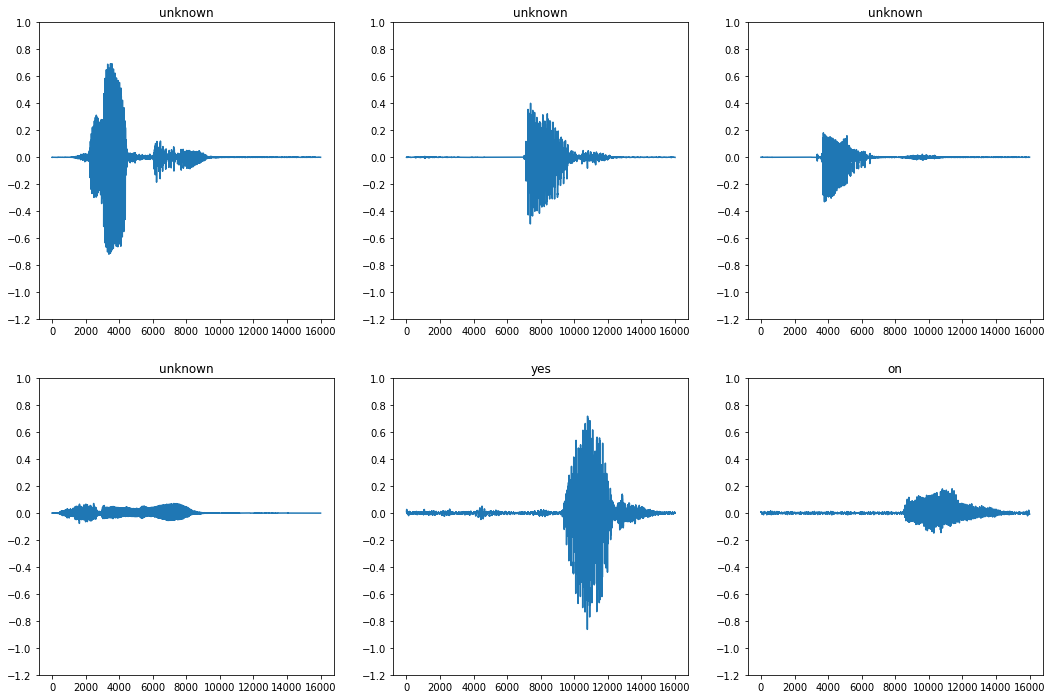

In [26]:
rows = 2
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(18, 12))
for i, (audio, label) in enumerate(waveform_ds.take(n)):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    ax.plot(audio.numpy())
    ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
    label = label.numpy().decode('utf-8')
    ax.set_title(label)

plt.show()

Here I will recheck whether I have samples with rate larger than 16K

In [27]:
large_files = False

for i, (audio, label) in enumerate(waveform_ds):
    if audio.numpy().shape[0] > 16000:
        large_files = True
        print (audio.numpy().shape[0], label)

if not large_files:
    print("There are no files with rate larger than 16K.")

There are no files with rate larger than 16K.


## Create Spectrogram using STFT (Short-Time Fourie Transform)

I'll convert the waveform into a spectrogram, which shows frequency changes over time and can be represented as a 2D image. This can be done by applying the **short-time Fourier transform (STFT)** to convert the audio into the time-frequency domain.

The STFT (`tf.signal.stft`) splits the signal into windows of time and runs a Fourier transform on each window, preserving some time information, and returning a 2D tensor that you can run standard convolutions on.

Choose `frame_length` and `frame_step` parameters such that the generated spectrogram "image" is almost square.

I also want the waveforms with same length, so the spectrogram images will have similar dimensions. Some of our files are shorter then 1 second, so I will apply zero padding.

In [28]:
def get_spectrogram(waveform):
    zero_padding = tf.zeros([16000] - tf.shape(waveform), dtype=tf.float32)
    waveform = tf.cast(waveform, tf.float32)
    equal_length = tf.concat([waveform, zero_padding], 0)
    spectrogram = tf.signal.stft(
        equal_length, 
        frame_length=255, 
        frame_step=128
    )

    spectrogram = tf.abs(spectrogram)
    return spectrogram

Here is a sample of audio file with its label, waveform and spectrogram shapes

In [29]:
for waveform, label in waveform_ds.take(8):
    label = label.numpy().decode('utf-8')
    spectrogram = get_spectrogram(waveform)

print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
print('Audio playback')
display.display(display.Audio(waveform, rate=16000))

Label: unknown
Waveform shape: (16000,)
Spectrogram shape: (124, 129)
Audio playback


Create a spectrogram of the previously chosen sound

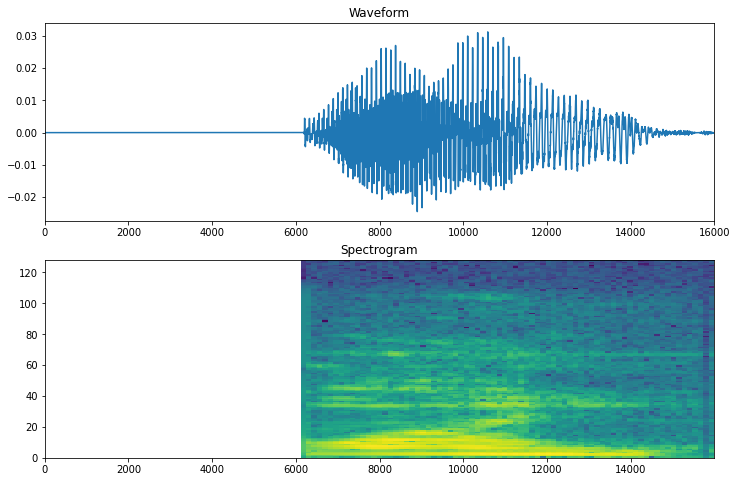

In [30]:
def plot_spectrogram(spectrogram, ax):
    # Convert to frequencies to log scale and transpose so that 
    # the time is represented in the x-axis (columns).
    log_spec = np.log(spectrogram.T)
    height = log_spec.shape[0]
    width = log_spec.shape[1]
    X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
    Y = range(height)
    ax.pcolormesh(X, Y, log_spec)


fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])
plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

Now I will transform the waveform dataset to have spectrogram images and their corresponding labels as integer IDs.

In [31]:
def get_spectrogram_and_label_id(audio, label):
    spectrogram = get_spectrogram(audio)
    spectrogram = tf.expand_dims(spectrogram, -1)
    label_id = tf.argmax(label == target_labels)
    return spectrogram, label_id

In [32]:
spectrogram_ds = waveform_ds.map(
    get_spectrogram_and_label_id, num_parallel_calls=AUTOTUNE
)

Let's explore random nine images of spectrogram for different samples

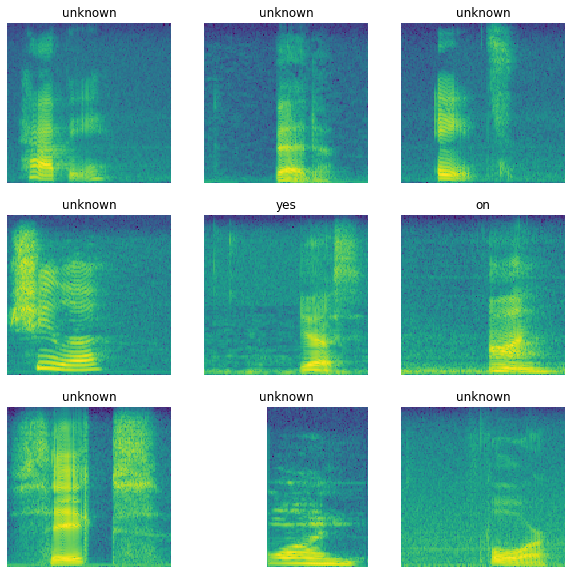

In [33]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(np.squeeze(spectrogram.numpy()), ax)
    ax.set_title(target_labels[label_id.numpy()])
    ax.axis('off')

plt.show()

# Build, train and save the Model

Preprocess the validation dataset

In [34]:
def preprocess_dataset(files):
    files_ds = tf.data.Dataset.from_tensor_slices(files)
    output_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)
    output_ds = output_ds.map(
        get_spectrogram_and_label_id,
        num_parallel_calls=AUTOTUNE
    )
    return output_ds

In [35]:
train_ds = spectrogram_ds
val_ds = preprocess_dataset(val_files)

I divide the train and validation sets into batches by 32

In [36]:
batch_size = 32
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

Add dataset `cache()` and `prefetch()` operations to reduce read latency while training the model.

In [37]:
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

For this baseline notebook I will initially build a simple CNN. 

The model has the following additional preprocessing layers:
* A `Resizing` layer to downsample the input to enable the model to train faster.
* A `Normalization` layer to normalize each pixel in the image based on its mean and standard deviation.

For the Normalization layer, its `adapt` method would first need to be called on the training data in order to compute aggregate statistics (i.e. mean and standard deviation).

In [38]:
for spectrogram, _ in spectrogram_ds.take(1):
    input_shape = spectrogram.shape
print('Input shape:', input_shape)

num_labels = len(target_labels)
norm_layer = preprocessing.Normalization()
norm_layer.adapt(train_ds.map(lambda x, _: x))
print("Normalization has been completed!")

model_cnn = models.Sequential([
    layers.Input(shape=input_shape),
    preprocessing.Resizing(64, 64), 
    norm_layer,
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.15),
    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.15),
    layers.Conv2D(256, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.20),
    layers.Conv2D(512, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.20),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.20),
    layers.Dense(num_labels),
 ])

model_cnn.summary()

Input shape: (124, 129, 1)
Normalization has been completed!
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing (Resizing)          (None, 64, 64, 1)         0         
_________________________________________________________________
normalization (Normalization (None, 64, 64, 1)         3         
_________________________________________________________________
conv2d (Conv2D)              (None, 62, 62, 64)        640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 29, 29, 128)       73856     
_____________________________________________________________

In [40]:
model_cnn.compile(
    optimizer=tf.keras.optimizers.Adam(lr=0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [41]:
EPOCHS = 50
history = model_cnn.fit(
    train_ds, 
    validation_data=val_ds,  
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=10),
)

Epoch 1/50
1730/1730 [==============================] - 39s 19ms/step - loss: 1.1821 - accuracy: 0.6821 - val_loss: 0.3701 - val_accuracy: 0.8807
Epoch 2/50
1730/1730 [==============================] - 15s 9ms/step - loss: 0.3938 - accuracy: 0.8768 - val_loss: 0.2384 - val_accuracy: 0.9269
Epoch 3/50
1730/1730 [==============================] - 15s 8ms/step - loss: 0.2890 - accuracy: 0.9112 - val_loss: 0.2139 - val_accuracy: 0.9335
Epoch 4/50
1730/1730 [==============================] - 15s 8ms/step - loss: 0.2444 - accuracy: 0.9236 - val_loss: 0.1907 - val_accuracy: 0.9404
Epoch 5/50
1730/1730 [==============================] - 15s 9ms/step - loss: 0.2209 - accuracy: 0.9319 - val_loss: 0.1979 - val_accuracy: 0.9407
Epoch 6/50
1730/1730 [==============================] - 15s 8ms/step - loss: 0.2036 - accuracy: 0.9381 - val_loss: 0.1700 - val_accuracy: 0.9486
Epoch 7/50
1730/1730 [==============================] - 15s 9ms/step - loss: 0.1960 - accuracy: 0.9409 - val_loss: 0.1743 - val_a

Here are taraining and validation loss curves, so you we can see how the model has improved during the training 

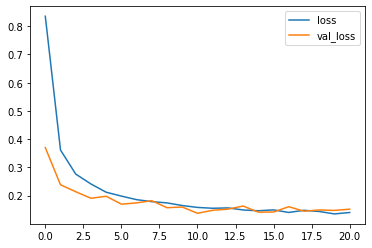

In [42]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

## Save the Model

Choose a method to save the entire model: there is native Tensorflow method SavedModel and  saving into a HDF5 file.

In [44]:
#shutil.os.mkdir(path + 'saved_model')

# Save the entire model as a SavedModel.
# model_cnn.save('saved_model/model_cnn')

# Save the entire model as HDF5 file
model_cnn.save('model_cnn_2.h5')

In [45]:
#!rm -rf kaggle/working/structured/*
#gc.collect()

30447

## Load the saved Model

In [ ]:
LOAD_MODEL = True

In [ ]:
 if LOAD_MODEL:
        
    model_cnn = tf.keras.models.load_model('/kaggle/input/trained-cnn-model/model_cnn.h5')

    # Check its architecture
    model_cnn.summary()

Before we start process the test dataset clean the RAM

In [ ]:
del total_filenames, filenames, train_files, val_files, train_ds, val_ds
gc.collect()

# Arrangement of Submission File 

We have very large test dataset - its size ~ 7 GB. We can encounter the lack of RAM memory during of unpacking and processing. Be aware of this issue! 

Unzip the test dataset and the sample of submission file 

In [ ]:
!apt-get install -y p7zip-full
!7z x ../input/tensorflow-speech-recognition-challenge/test.7z
!7z x ../input/tensorflow-speech-recognition-challenge/sample_submission.7z

Define path for test datset directory

In [ ]:
tst_dir = '../working/test/audio/'

## Preprocess the test dataset

I repeat some operations of preprocessing as were applied to the train/validation datasets

In [ ]:
test_filenames = tf.io.gfile.glob(str(tst_dir) + '*.wav')
num_samples = len(test_filenames)

print('Number of total examples:', num_samples)
print('Example file tensors:', test_filenames[0])

In [ ]:
def decode_audio(audio_binary):
    audio, _ = tf.audio.decode_wav(audio_binary)
    return tf.squeeze(audio, axis=-1)

The test daatset does not have labels -our Model shall define a label for each file. So I get name of audio file here...

In [ ]:
def get_fname(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-1]

In [ ]:
def get_waveform_and_fname(file_path):
    fname = get_fname(file_path)
    audio_binary = tf.io.read_file(file_path)
    waveform = decode_audio(audio_binary)
    return waveform, fname

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
test_files_ds = tf.data.Dataset.from_tensor_slices(test_filenames)
test_waveform_ds = test_files_ds.map(get_waveform_and_fname, num_parallel_calls=AUTOTUNE)

Let's build a few plots of sound files from the test dataset 

In [ ]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))
for i, (audio, fname) in enumerate(test_waveform_ds.take(n)):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    ax.plot(audio.numpy())
    ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
    fname = fname.numpy().decode('utf-8')
    ax.set_title(fname)

plt.show()

I will also pad short files with zero

In [ ]:
def get_spectrogram(waveform):
    zero_padding = tf.zeros([16000] - tf.shape(waveform), dtype=tf.float32)
    waveform = tf.cast(waveform, tf.float32)
    equal_length = tf.concat([waveform, zero_padding], 0)
    spectrogram = tf.signal.stft(
        equal_length, 
        frame_length=255, 
        frame_step=128
    )

    spectrogram = tf.abs(spectrogram)

    return spectrogram

In [ ]:
for waveform, fname in test_waveform_ds.take(1):
    fname = fname.numpy().decode('utf-8')
    spectrogram = get_spectrogram(waveform)

print('File name:', fname)    
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
print('Audio playback')
display.display(display.Audio(waveform, rate=16000))

Now I willl examine a few random spectrogram images of sound files from the test dataset

In [ ]:
def get_spectrogram_and_fname(audio, fname):
    spectrogram = get_spectrogram(audio)
    return spectrogram, fname

In [ ]:
test_spectrogram_ds = test_waveform_ds.map(
    get_spectrogram_and_fname, 
    num_parallel_calls=AUTOTUNE
)

In [ ]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
for i, (spectrogram, fname) in enumerate(test_spectrogram_ds.take(n)):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(np.squeeze(spectrogram.numpy()), ax)
    ax.set_title(fname.numpy().decode('utf-8'))
    ax.axis('off')

plt.show()

In [ ]:
test_ds = test_spectrogram_ds
batch_size = 32
test_ds = test_ds.batch(batch_size)

In [ ]:
gc.collect()

## Make prediction and save submission file

In [ ]:
index = []
output = []

for audio, fnames in test_ds:   
    prediction = np.argmax(model_cnn.predict(audio), axis=1)   # model_cnn
    prediction = [target_labels[n] for n in prediction]
    index.extend(fnames.numpy())
    output.extend(prediction)
        
index = [name.decode('UTF-8') for name in index]        
df = pd.DataFrame(columns=['fname', 'label'])
df['fname'] = index
df['label'] = output
df.to_csv('submission.csv', index=False)
print("Shape of the submission dataset:", df.shape)

## End of Notebook